# Correcting phase flip errors

Step by step implementation of the quantum circuit for the correction of a phase flip error on a single qubit.

## Importing needed modules

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info.states import Statevector
from math import sqrt

## Encoding

To detect and correct the phase flip error we'll use the follwoing encoding:<br><br>
$|\psi\rangle =  \alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|+++\rangle + \beta|---\rangle$

## Inizializing the circuit

To implement the ciurcuit we need:
- 3 qubits for the encoding, where the first will initially contain the state $|\psi\rangle$ that we want to protect
- 2 ancillary qubits that we'll use to store the information about the error syndrome
- A classical register of 2 bits, to store thre result of the measurement of the 2 ancillary qubits and use it for the correction

We'll use as initial state: $|\psi\rangle = \sqrt{\frac{3}{4}}|0\rangle + \sqrt{\frac{1}{4}}|1\rangle$

Initial state: 0.866|0> + 0.5|1>


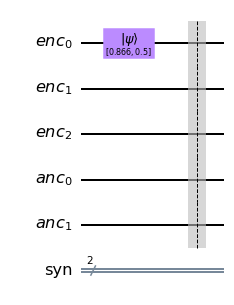

In [2]:
q_enc = QuantumRegister(3, "enc")
q_anc = QuantumRegister(2, "anc")
c_syn = ClassicalRegister(2, "syn")

alpha = sqrt(3/4)
beta = sqrt(1/4)

init_state = [alpha, beta]

qc = QuantumCircuit(q_enc, q_anc, c_syn)

qc.initialize(init_state, [q_enc[0]])

qc.barrier()

print(f"Initial state: {round(alpha, 3)}|0> + {round(beta, 3)}|1>")

qc.draw(output="mpl")

## Implementing the encoding

The first qubit is the qubit we want to encode is in the first qubit. The initial state is:<br><br>
$(\alpha|0\rangle + \beta|1\rangle)|0\rangle|0\rangle =  \alpha|000\rangle + \beta|100\rangle$
<br><br>
After the first CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|110\rangle$
<br><br>
After the second CNOT gate it becomes:<br><br>
$\alpha|000\rangle + \beta|111\rangle$
<br><br>
Then after allpying the Hadamard gates to each qubit we get:<br><br>
$\alpha|+++\rangle + \beta|---\rangle$
<br><br>
which is the encoding we wanted.


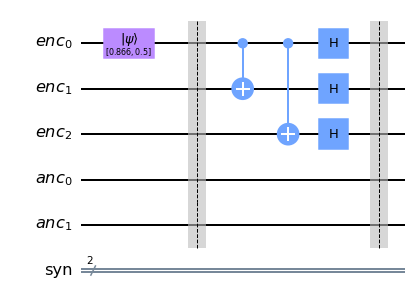

In [3]:
qc.cx(q_enc[0], q_enc[1])
qc.cx(q_enc[0], q_enc[2])
qc.h(q_enc[0])
qc.h(q_enc[1])
qc.h(q_enc[2])

qc.barrier()

qc.draw(output="mpl")

## Simulate the phase flip error

We simulate a bit flip error by adding a $Z$ gate on the second qubit

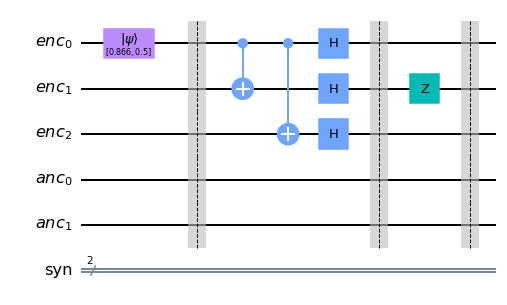

In [4]:
qc.z(q_enc[1])
qc.barrier()

qc.draw(output="mpl")

## Implementing the error detection circuit

We apply the circuit stores in the ancillary qubits the syndrome of on which of the three qubits the bit flip error occured (if it occured), and then we measure the ancillary qubits.

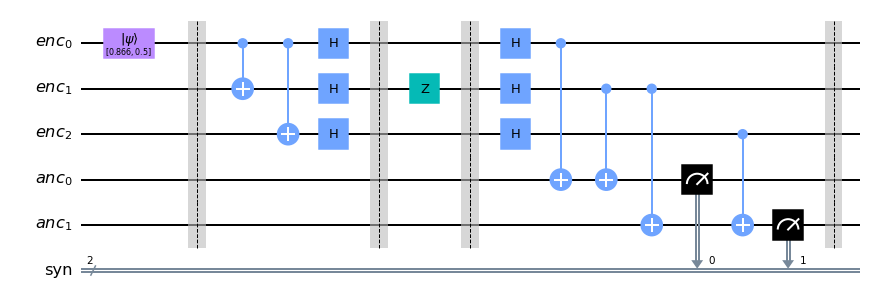

In [5]:
qc.h(q_enc[0])
qc.h(q_enc[1])
qc.h(q_enc[2])

qc.cx(q_enc[0], q_anc[0])
qc.cx(q_enc[1], q_anc[0])
qc.cx(q_enc[1], q_anc[1])
qc.cx(q_enc[2], q_anc[1])

qc.measure(q_anc[0], c_syn[0])
qc.measure(q_anc[1], c_syn[1])
qc.barrier()
qc.draw("mpl")

## Recovery circuit

We correct the error based on the value of the measure of the two ancillary qubits. The possible values of the measurement are the following:
- 00: means no error
- 10: means phase flip error on the first qubit
- 11: means phase flip error on the second qubit
- 01: means phase flip error on the third qubit

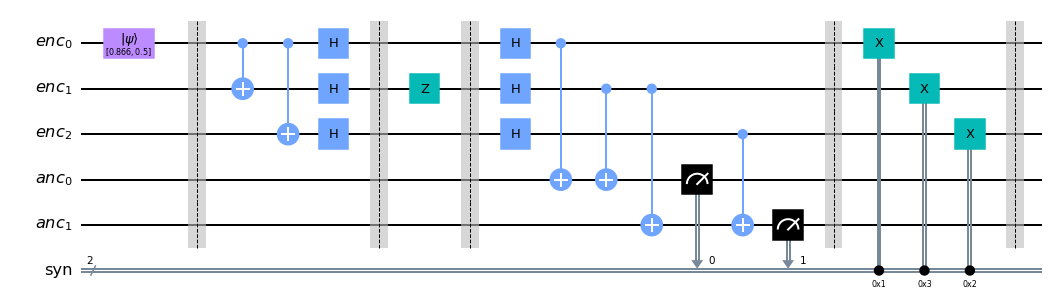

In [6]:
qc.x(q_enc[0]).c_if(c_syn, 1)
qc.x(q_enc[1]).c_if(c_syn, 3)
qc.x(q_enc[2]).c_if(c_syn, 2)
qc.barrier()

qc.draw("mpl")

## Decoding circuit
We decode $\alpha|+++\rangle + \beta|---\rangle$ back to $\alpha|000\rangle + \beta|100\rangle$, so that we have $\alpha|0\rangle + \beta|1\rangle$ on the first qubit.

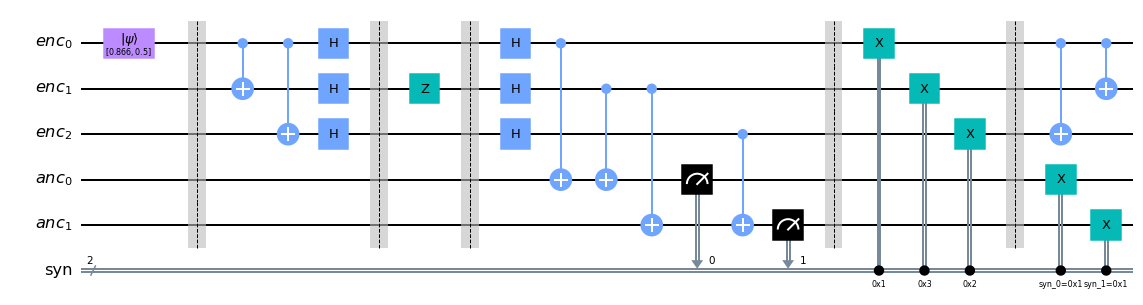

In [7]:
qc.cx(q_enc[0], q_enc[2])
qc.cx(q_enc[0], q_enc[1])

# set ancillary qubits to 0. Not necessary, it is just to 
# extract the amplitudes of the first qubit from the 
# state vector at the end
qc.x(q_anc[0]).c_if(c_syn[0], 1)
qc.x(q_anc[1]).c_if(c_syn[1], 1)

qc.draw("mpl")

## Executing the circuit
We execute the cirucit showing $|\psi\rangle$ at the end, and the error syndrome measured. 

In [8]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
alpha_out = outputstate[0]
beta_out = outputstate[1]

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000)
syndrome = job.result().get_counts(qc)
print(f"Initial state: {alpha}|0> + {beta}|1>")
print(f"\nSyndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"\nDecoded state: {alpha_out}|0> + {beta_out}|1>")

Initial state:
0.8660254037844386|0> + 0.5|1>
Syndrome qubits: 11
Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>


## Defining a test function

We define a function to make the cirucit easier to test of different errors and different input qubits. The function takes as input arguments:
- `input_qubit`: which is a list of two elements, where the first is the amplitude of $|0\rangle$ and the second is the amplitude of $|1\rangle$
- `error_mask`: which is tuple of three elements, where if the element in position $i$ is 1 it means that there will be a phase flip error on the $i$-th qubit after the encoding, if it is 0 there will be no error on tht qubit. For example if we use as error mask (1,0,1) it means that there will be a phase flip error on the first and on the third qubit of the encoded state

In [9]:
def circuit(input_qubit, error_mask):
    
    # initialization
    q_enc = QuantumRegister(3, "enc")
    q_anc = QuantumRegister(2, "anc")
    c_syn = ClassicalRegister(2, "syn")
    
    qc = QuantumCircuit(q_enc, q_anc, c_syn)
    qc.initialize(input_qubit, [q_enc[0]])
    qc.barrier()
    
    
    # encoding 
    qc.cx(q_enc[0], q_enc[1])
    qc.cx(q_enc[0], q_enc[2])
    qc.h(q_enc[0])
    qc.h(q_enc[1])
    qc.h(q_enc[2])
    
    qc.barrier()

    # error
    if error_mask[0] == 1:
        qc.z(q_enc[0])
    if error_mask[1] == 1:
        qc.z(q_enc[1])
    if error_mask[2] == 1:
        qc.z(q_enc[2])
    
    qc.barrier()
    
    
    # error syndrome
    qc.h(q_enc[0])
    qc.h(q_enc[1])
    qc.h(q_enc[2])
    
    qc.cx(q_enc[0], q_anc[0])
    qc.cx(q_enc[1], q_anc[0])
    qc.cx(q_enc[1], q_anc[1])
    qc.cx(q_enc[2], q_anc[1])

    qc.measure(q_anc[0], c_syn[0])
    qc.measure(q_anc[1], c_syn[1])
    qc.barrier()
    
    # recovery
    qc.x(q_enc[0]).c_if(c_syn, 1)
    qc.x(q_enc[1]).c_if(c_syn, 3)
    qc.x(q_enc[2]).c_if(c_syn, 2)
    qc.barrier()
    
    # decoding
    qc.cx(q_enc[0], q_enc[2])
    qc.cx(q_enc[0], q_enc[1])
    
    # setting the ancillary qubits to 0
    qc.x(q_anc[0]).c_if(c_syn[0], 1)
    qc.x(q_anc[1]).c_if(c_syn[1], 1)
    
    
    # get state vector    
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(qc)
    result = job.result()
    outputstate = result.get_statevector(qc, decimals=3)
    # print(outputstate)
    alpha = outputstate[0]
    beta = outputstate[1]

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1)
    syndrome = job.result().get_counts(qc)
    
    return alpha, beta, syndrome, qc

You can play with the below code cell, by varying the values of the input parameters of the function.

Input state:
0.866|0> + 0.5|1>

Syndrome qubits: 11

Decoded state:
(0.866-0j)|0> + (0.5-0j)|1>


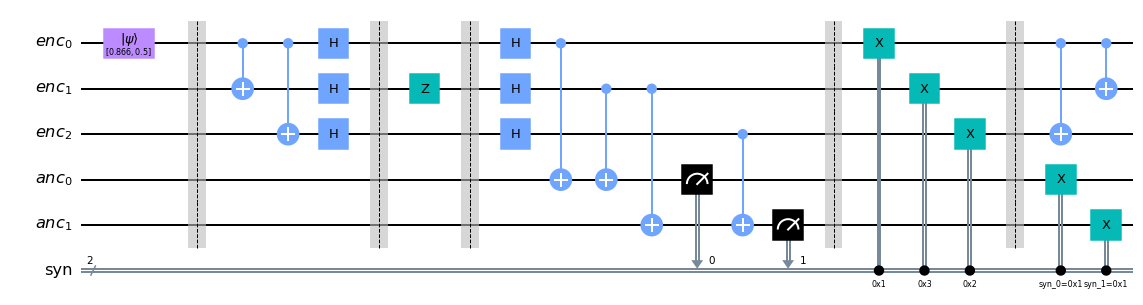

In [13]:
alpha_in = sqrt(3/4) # amplitude of |0> 
beta_in = sqrt(1/4) # amplitude of |1>
input_qubit = [alpha_in, beta_in]
error_mask = (0,1,0) # error mask

alpha, beta, syndrome, qc = circuit(input_qubit, error_mask)
print(f"Input state: {round(alpha_in, 3)}|0> + {round(beta_in, 3)}|1>")
print(f"\nSyndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"\nDecoded state: {alpha}|0> + {beta}|1>")
qc.draw("mpl")